## Задание 1. A/B–тестирование
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей

### 0. Считывание данных

In [1]:
# Импортирую библиотеки

import pandas as pd
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency, chi2
import scipy.stats as ss
import scipy
from scipy. stats import norm

In [2]:
# Прописываю ссылки для скачивания с Яндекс.Диска

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
groups_url = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [3]:
# Создаю функцию для чтения файлов по ссылке

def get_data(url):
    final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [4]:
# Применяю функцию и считываю файлы, указываю разделитель 

groups = pd.read_csv(get_data(groups_url), sep = ';')
groups_add = pd.read_csv(get_data(groups_add_url), sep = ',')
active_studs = pd.read_csv(get_data(active_studs_url))
checks = pd.read_csv(get_data(checks_url), sep = ';')

### 1. EDA
#### 1.1 Таблица groups  

Смотрю структуру таблицы, тип данных, кол-во столбов и строк, возможные значения в столбце grp, пропущенные значения

In [5]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
groups.dtypes

id      int64
grp    object
dtype: object

In [7]:
groups.shape

(74484, 2)

In [8]:
groups.id.nunique()

74484

Кол-во id совпадает с кол-вом строк, то есть все id в таблице являются уникальными

In [9]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [10]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

#### 1.2 То же самое по таблице groups_add 

In [11]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [12]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [13]:
groups_add.shape

(92, 2)

In [14]:
groups_add.id.nunique()

92

Кол-во id совпадает с кол-вом строк, то есть все id в таблице являются уникальными

In [15]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [16]:
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

groups_add - это файл с дополнительными пользователями, объединим его с основным файлом groups

In [17]:
groups_all = pd.concat([groups, groups_add])
groups_all.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Проверим, что кол-во строк в 2 изначальных таблицах равно кол-ву строк в объединенной таблице, ничего не потерялось

In [18]:
groups_all.shape[0] == groups.shape[0] + groups_add.shape[0]

True

#### 1.3 Таблица active_studs

Смотрю структуру таблицы, тип данных, кол-во столбов и строк,пропущенные значения

In [19]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [20]:
# Переименую столбец student_id, чтобы его можно было сопоставлять с id из таблицы groups_all

active_studs = active_studs.rename(columns = {'student_id' : 'id'})
active_studs.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [21]:
active_studs.dtypes

id    int64
dtype: object

In [22]:
active_studs.shape

(8341, 1)

In [23]:
active_studs.id.nunique()

8341

Кол-во id совпадает с кол-вом строк, то есть все id в таблице являются уникальными

In [24]:
active_studs.isna().sum()

id    0
dtype: int64

#### 1.4 Таблица checks
То же самое по таблице checks

In [25]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [26]:
checks = checks.rename(columns = {'student_id' : 'id'})
checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [27]:
checks.dtypes

id       int64
rev    float64
dtype: object

In [28]:
checks.shape

(541, 2)

In [29]:
checks.id.nunique()

541

Кол-во id совпадает с кол-вом строк, то есть все id в таблице являются уникальными

In [30]:
checks.isna().sum()

id     0
rev    0
dtype: int64

#### 1.5 Поиск взаимосвязей между данными
Исходные данные:    
группа A - базовая механика оплаты на сайте (контрольная группа)  
группа B - новая механика оплаты (тестовая группа)

Проанализируем таблицы с активными пользователями и пользователями, которые совершили оплату.

In [31]:
# Посчитаем кол-во пользователей, совершивших оплату 

checks.id.nunique()

541

In [32]:
# Посчитаем, сколько пользователей из таблицы checks есть в таблице active_studs

checks.id.isin(active_studs.id).sum()

392

То есть 149 пользователей (541-392) совершили оплату, но не заходили на сайт,так как их нет в таблице активных пользователей.

In [33]:
# Выведем данных пользователей в отдельную таблицу

paid_not_active = checks.loc[~checks.id.isin(active_studs.id)]
paid_not_active

,id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0
...,...,...
508,5291900,199.0
512,5331842,290.0
521,5486319,199.0
530,5562806,398.0


Возможно существуют какие-то варианты оплаты не через сайт или данные пользователи уже находились на сайте до момента начала логирования активных пользователей. В любом случае, нам нужны активные пользователи, поэтому данных пользователей я не буду учитывать.

Отберем только тех пользователей, которые являются активными (есть в таблице active_studs), и для них добавим информацию об оплатах из таблицы checks, а также информацию о группе из таблицы groups_all. Исходная таблица готова

In [34]:
full_df = active_studs.merge(checks, on = 'id', how = 'left') \
                      .merge(groups_all, on = 'id', how = 'left')
full_df

,id,rev,grp
0,581585,NaN,A
1,5723133,NaN,A
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B
...,...,...,...
8336,1794344,NaN,B
8337,296883,NaN,B
8338,3598448,NaN,B
8339,3610547,290.0,B


Проверим отсутствующие значения в таблице. В столбце rev отсутствуют значения по тем пользователям, которые не совершали оплату. В столбце grp нет отсутствующих значений, то есть для каждого пользователя мы знаем его принадлежность к группе. 

In [35]:
full_df.isna().sum()

id        0
rev    7949
grp       0
dtype: int64

Мы видим, что в тестовой группе гораздо больше людей, чем в контрольной

In [36]:
full_df.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

Посмотрим распределение суммы оплаты

In [37]:
full_df.groupby('grp').rev.describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0
B,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0


In [38]:
full_df.query('grp == "A"').rev.value_counts().head(10)

290.0     25
580.0      6
199.0      5
590.0      5
990.0      5
690.0      4
3660.0     3
840.0      3
1530.0     3
2910.0     2
Name: rev, dtype: int64

In [39]:
full_df.query('grp == "B"').rev.value_counts().head(10)

1900.0000    93
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
990.0000     17
690.0000     13
1140.0000     9
398.0000      6
590.0000      6
Name: rev, dtype: int64

Мы видим, что в тестовой группе большое кол-во участников сделало оплату на 1900 (или 1900,0001) по сравнению с контрольной группой. Возможно новая механика оплаты была связана с тем, что при достижении данной суммы заказа предоставлялся какой-то бонус (скидка/бесплатная доставка/отсутствие комиссии за оплату и тд) или это сумма подписки на определенный период. Также и в группе А есть сумма (290), которая встречается намного чаще других.

## 2. Метрики

Таким образом, у нас есть активные пользователи, часть которых не совершала оплату на сайте, а часть оплатила, и мы знаем сумму заказа каждого оплатившего пользователя.  
Так как мы не знаем,в чем конкрентно состоял эксперимент с внедрением новой механики оплаты (было это связано только с удобством оплаты или с проведением каких-то акций в зависимости от суммы оплаты), для анализа я буду использовать несколько метрик:
- конверсия активного пользователя в оплату - посмотрю, привела ли новая механика оплаты к тому, что больше пользователей стали совершать оплату на сайте  
- ARPAU (Average Revenue Per Active User) - проанализирую, выросла ли средняя сумма оплаты для активных пользователей в связи с новой механикой оплаты (стали ли в среднем тратить больше в расчете на 1 активного пользователя)
- ARPPU (Average Revenue Per Paying User) - посмотрю то же самое, но в расчете на 1 платящего пользователя (сподвигла ли новая механика оплаты тратить больше платящих пользователей)


#### 2.1 Конверсия активного пользователя в покупку

In [40]:
# Создаю дополнительный столбец, который будет принимать значение 1 или 0 в зависимости от того, была ли оплата 
# (есть ли значение в столбце rev)

full_df['rev_category'] = np.where(full_df.rev.isna() == True, 0, 1)
full_df.head()

,id,rev,grp,rev_category
0,581585,NaN,A,0
1,5723133,NaN,A,0
2,3276743,NaN,B,0
3,4238589,NaN,A,0
4,4475369,NaN,B,0


In [41]:
# Создаю таблицу сопряженности, подсчитывающую кол-во значений в разрезе группы (A/B) и наличия оплаты (1-да, 0-нет)

cr = pd.crosstab(full_df.grp, full_df.rev_category)
cr

rev_category,0,1
grp,,
A,1460,78
B,6489,314


In [42]:
# считаю конверсию в оплату (в процентах)

cr['cr'] = (cr[1] / (cr[0] + cr[1])).mul(100).round(2)
cr

rev_category,0,1,cr
grp,,,
A,1460,78,5.07
B,6489,314,4.62


Конверсия в оплату у тестовой группы меньше, чем у контрольной. Посмотрим в пункте 3, можно ли опираться на данный результат после проверки статистической значимости.

#### 2.2 ARPAU (Average Revenue Per Active User)

In [43]:
# считаю кол-во пользователей и сумму оплаты в разрезе групп А и В

arpau = full_df.groupby('grp', as_index = False) \
               .agg({'id' : 'count', 'rev' : 'sum'})
arpau

,grp,id,rev
0,A,1538,72820.0000
1,B,6803,394974.0035


In [44]:
# Вычисляю ARPAU

arpau['arpau'] = (arpau.rev / arpau.id).round(2)
arpau

,grp,id,rev,arpau
0,A,1538,72820.0000,47.35
1,B,6803,394974.0035,58.06


ARPAU у тестовой группы выше, чем у контрольной. Посмотрим в пункте 3, можно ли опираться на данный результат после проверки статистической значимости

#### 2.3 ARPPU (Average Revenue Per Paying User)

In [45]:
# Оставляю только платящих пользователей и считаю кол-во пользователей и сумму оплаты в разрезе групп А и В

arppu = full_df.query('rev_category == 1') \
               .groupby('grp', as_index = False) \
               .agg({'id' : 'count', 'rev' : 'sum'})
arppu

,grp,id,rev
0,A,78,72820.0000
1,B,314,394974.0035


In [46]:
arppu['arppu'] = (arppu.rev / arppu.id).round(2)
arppu

,grp,id,rev,arppu
0,A,78,72820.0000,933.59
1,B,314,394974.0035,1257.88


ARPPU у тестовой группы выше, чем у контрольной. Посмотрим в пункте 3, можно ли опираться на данный результат после проверки статистической значимости

## 3. Проверка статистической значимости

#### 3.1 Конверсия активного пользователя в оплату

У нас есть 2 категориальные переменные: группа (A,B) и факт оплаты (0,1). Наша метрика является конверсией. Поэтому статистическую значимость я буду проверять с помощью критерия хи-квадрат.

Зададим гипотезы:

𝐻0
 : взаимосвязи между переменными нет  
𝐻1
 : взаимосвязь есть

In [47]:
pd.crosstab(full_df.grp, full_df.rev_category)

rev_category,0,1
grp,,
A,1460,78
B,6489,314


In [48]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(full_df.grp, full_df.rev_category))

In [49]:
stat, p

(0.48480826522557896, 0.48625240457231045)

In [50]:
if p < 0.05:
    print ('Отклоняем Ho')
else:
    print ('Отклоняем H1')

Отклоняем H1


p-value больше 0,05, значит мы принимаем Ho об отсутствии взаимосвязи и делаем вывод, что взаимосвязь между переменными статистически незначима. Значит использовать метрику конверсии в оплату для принятия решения об эффективности новой механики оплаты нельзя.

#### 3.2 ARPAU и ARPPU

In [51]:
# Выделим отдельно суммы оплат в группах А и В (отберем только те строки,в которых есть сумма оплаты)

rev_A = full_df.query('grp == "A" & rev_category == 1').rev
rev_B = full_df.query('grp == "B" & rev_category == 1').rev

Посмотрим распределение суммы оплаты в зависимости от группы на графиках

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


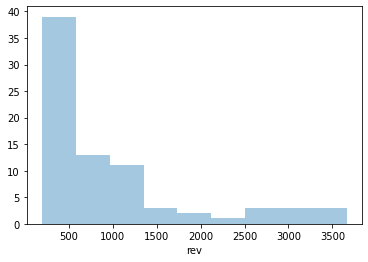

In [52]:
sns.distplot(rev_A, kde = False)

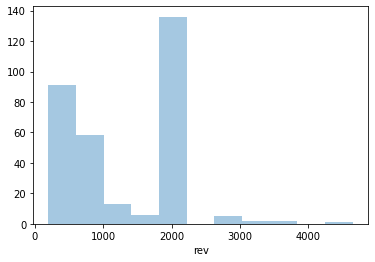

In [53]:
sns.distplot(rev_B, kde = False)

Проверим нормальность данных в группе A с помощью теста Агостино-Пирсона:  
H0 - значения распределены нормально  
H1 - значения распределены ненормально

In [54]:
scipy.stats.normaltest(rev_A)

NormaltestResult(statistic=30.378419638487458, pvalue=2.531686880422046e-07)

In [55]:
if scipy.stats.normaltest(rev_A)[1] < 0.05:
    print ('Отклоняем Ho')
else:
    print ('Отклоняем H1')

Отклоняем Ho


Вывод:p-value < 0.05, отклоняем Ho о нормальном распределении, значения в группе A распределены ненормально

Проверим нормальность данных в группе B.

In [56]:
scipy.stats.normaltest(rev_B)

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

In [57]:
if scipy.stats.normaltest(rev_B)[1] < 0.05:
    print ('Отклоняем Ho')
else:
    print ('Отклоняем H1')

Отклоняем Ho


Вывод:p-value < 0.05, отклоняем Ho о нормальном распределении, значения в группе B распределены ненормально

Проверим гомогенность дисперсий в группах с помощью теста Левена:  
    H0 - дисперсии гомогенны  
    Н1 - дисперсии негомогенны

In [58]:
scipy.stats.levene(rev_A,rev_B, center='median')

LeveneResult(statistic=3.0756816999816055, pvalue=0.08025675761347022)

In [59]:
if scipy.stats.levene(rev_A,rev_B, center='median')[1] < 0.05:
    print ('Отклоняем Ho')
else:
    print ('Отклоняем H1')

Отклоняем H1


pvalue > 0.05, принимаем H0 о гомогенности дисперсий

Посмотрим на графике наличие выбросов. В обеих группах есть выбросы.

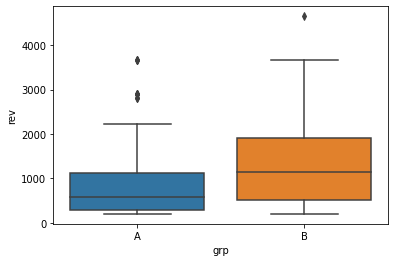

In [60]:
sns.boxplot(data = full_df, x = 'grp', y = 'rev')

Вывод: значения в группах распределены ненормально, есть выбросы. Плюс в группах есть большое количество повторений (что может быть ограничением для критерия Манна-Уитни), поэтому для проверки стат значимости я буду использовать bootstrap.

In [61]:
# Задаю функцию для генерации подвыборок из имеющихся выборок суммы оплат в группах А и В, рассчитываю средние в данных 
# подвыборках и каждый раз сохраняю в отдельный список разность средних двух подвыборок. Затем строю доверительный интервал 
# для данного распределения и считаю p-value. Визуализирую все на графике.

def get_bootstrap(
    rev_A, # числовые значения первой выборки (контрольная группа)
    rev_B, # числовые значения второй выборки (тестовая группа)
    boot_it, # количество бутстрэп-подвыборок
    statistic, # интересующая нас статистика
    bootstrap_conf_level # уровень значимости
):
    boot_len = max([len(rev_A), len(rev_B)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = rev_A.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = rev_B.sample(
            boot_len,
            replace = True
        ).values
        boot_data.append(statistic(samples_2-samples_1)) # сохраняем в список разность средних 2 подвыборок
    
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2 # считаем квантили 0.025 и 0.975 (границы доверительного интервала)
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data))
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2 # считаем p_value
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

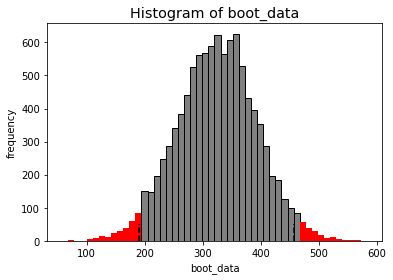

{'quants':                 0
 0.025  190.138069
 0.975  457.485440,
 'p_value': 2.0151345231481956e-06}

In [62]:
# Применяю функцию к нашим данным

get_bootstrap(rev_A, rev_B, 10000, np.mean, 0.95)

Доверительный интервал разности средних 2 групп не включает 0, p-value меньше 0.05. Можно сделать вывод, что средние 2 групп статистически значимо различаются между собой.   
Данный вывод можно применить и для ARPAU, и для ARPPU, так как для их расчета используются одни и те же распределения суммы оплат.

In [63]:
arpau

,grp,id,rev,arpau
0,A,1538,72820.0000,47.35
1,B,6803,394974.0035,58.06


In [64]:
arppu

,grp,id,rev,arppu
0,A,78,72820.0000,933.59
1,B,314,394974.0035,1257.88


Вывод: ARPAU и ARPPU в тестовой группе статистически значимо выше по сравнению с контрольной группой.

### 4. Общий вывод

В ходе анализа результатов A/B теста выявлены следущие "узкие" места:  
  - количество людей в тестовой группе в 4 раза больше, чем в контрольной (что странно, обычно наоборот);
  - в распределении суммы оплат встречается большое количество повторений (для суммы 1900 в тестовой группе и 290 в контрольной);
  - есть 149 пользователей, которые совершили оплату (есть в таблице checks), но которых нет в числе посетителей сайта (нет в таблице active_studs). 
  
Для принятия окончательного решения о результатах эксперимента необходимо разобраться с данными вопросами.    
Но так как у нас нет дополнительной информации, оставим данные вопросы как риторические.

Для анализа результатов А/В теста выбраны следующие метрики:
   - CR активного пользователя в оплату;
   - ARPAU;
   - ARPPU.  
   
Было выявлено, что статистически значимой взаимосвязи между использованием новой механики оплаты и CR нет. Поэтому несмотря на то, что CR в тестовой группе снизилась по сравнению с контрольной группой (на 0.45 п.п), сделать вывод о результатах теста по данной метрике нельзя.  
Метрики ARPAU и ARPPU статистически значимо выше в тестовой группе по сравнению с контрольной группой. Поэтому если новая механика оплаты была направлена на повышение суммы оплаты пользователя, то данную механику можно выкатывать на всех пользователей.  
  
P.S.: если новая механика была связана, например, с повышением удобства оплаты (добавлены новые способы оплаты и тд), и не предполагалось ее прямого влияния на сумму оплаты пользователя, тогда сложно сделать логический вывод, так как в этом случае ожидалось скорее бы увеличение конверсии в оплату, а не увеличение ARPAU и ARPPU.

## Задание 2. Python

#### 1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.  

In [65]:
# Задаю функцию для расчета метрик

def metrics(base_url, url):
    # Прописываю формулы для чтения файла по ссылке и считываю файл
    final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(final_url)
    download_url = response.json()['href']
    groups_add_new = pd.read_csv(download_url, sep = ',')

    # Объединяю новый файл с файлом groups. По активным пользователям (таблица active_studs) добавляю иниформацию об оплатах 
    # (таблица checks) и распределении по группам (таблица groups_all_new)
    groups_all_new = pd.concat([groups, groups_add_new])
    full_df_new = active_studs.merge(checks, on = 'id', how = 'left') \
                          .merge(groups_all_new, on = 'id', how = 'left')
    
    # Добавляю отдельный столбец,который будет принимать значение 1 или 0 в зависимости от того, была ли оплата.
    # Вывожу в разрезе групп: кол-во оплативших студентов, кол-во студентов всего, сумму оплат
    full_df_new['rev_category'] = np.where(full_df_new.rev.isna() == True ,0, 1)
    full_df_group = full_df_new.groupby('grp', as_index = False) \
                             .agg({'rev_category' : 'sum', 'id' : 'count', 'rev' : 'sum'}) \
                             .rename(columns = {'rev_category' : 'number_paid', 'id' : 'number_total'})
    # Считаю метрики
    full_df_group['cr'] = (full_df_group.number_paid / full_df_group.number_total).mul(100).round(2)
    full_df_group['ARPAU'] = (full_df_group.rev / full_df_group.number_total).round(2)
    full_df_group['ARPPU'] = (full_df_group.rev / full_df_group.number_paid).round(2)
    return full_df_group

In [66]:
# Задаю ссылки для API и для конкретного файла

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

In [67]:
# Применяю функцию

metrics_data = metrics(base_url, url)
metrics_data

,grp,number_paid,number_total,rev,cr,ARPAU,ARPPU
0,A,78,1538,72820.0000,5.07,47.35,933.59
1,B,314,6803,394974.0035,4.62,58.06,1257.88


#### 2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [68]:
# Пишу функцию для построения графиков

def graphics(data):
    fig, axes = plt.subplots(1, 3, figsize=(15, 6)) 
    sns.barplot(data = data, x = 'grp', y = 'cr', ax=axes[0]).set(title = 'CR to payment', xlabel = 'group', ylabel = '')
    sns.barplot(data = data, x = 'grp', y = 'ARPAU', ax=axes[1]).set(title = 'ARPAU', xlabel = 'group', ylabel = '')
    sns.barplot(data = data, x = 'grp', y = 'ARPPU', ax=axes[2]).set(title = 'ARPPU', xlabel = 'group', ylabel = '')
    plt.show()

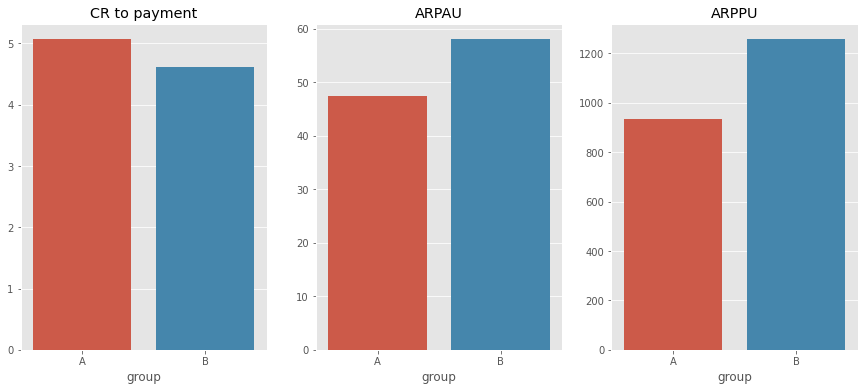

In [69]:
# Применяю функцию к датафрейму

graphics(metrics_data)